# LSTM Experiments


## Set-Up

### Imports

This notebook makes extensive use of the `tensorflow` library in order to create and train an LSTM.

`pandas` is used to read and store the dataset in a `DataFrame` object. `scitkit-learn` is used to produce confusion matrices and performance reports during testing.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import Input, Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import (Bidirectional, Concatenate, Dense,
    Embedding, InputLayer, LSTM, TextVectorization)
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

from sklearn.metrics import (accuracy_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay)

import re

np.random.seed(61332)

In [2]:
# If using Google Colab
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Filepaths

In [3]:
# Base path
# BASE_PATH = r"/content/drive/MyDrive/relation-extraction"
BASE_PATH = r"."

# Checkpoint paths and filenames
CKPT_PATH = r"/checkpoints"
CKPT_FILE = r"checkpoint"
CKPT_EXT = r".ckpt"

CKPT_PATH_0 = BASE_PATH + CKPT_PATH + r"/" + CKPT_FILE + "_0" + CKPT_EXT
CKPT_PATH_10 = BASE_PATH + CKPT_PATH + r"/" + CKPT_FILE + "_10" + CKPT_EXT
CKPT_PATH_11 = BASE_PATH + CKPT_PATH + r"/" + CKPT_FILE + "_11" + CKPT_EXT

# Dataset paths and filenames
DATA_PATH = r"/dataset"
TRAIN_FILE = r"train"
DEV_FILE = r"dev"
TEST_FILE = r"test"
DATA_EXT = r".json"

TRAIN_PATH = BASE_PATH + DATA_PATH + r"/" + TRAIN_FILE + DATA_EXT
DEV_PATH = BASE_PATH + DATA_PATH + r"/" + DEV_FILE + DATA_EXT
TEST_PATH = BASE_PATH + DATA_PATH + r"/" + TEST_FILE + DATA_EXT

# Model save paths and filenames
MODEL_PATH = r"/keras_models"
MODEL0_FILE = r"model0"
MODEL10_FILE = r"model10"
MODEL11_FILE = r"model11"
MODEL1_FILE = r"model1"
MODEL_EXT = r".keras"

MODEL0_PATH =  BASE_PATH + MODEL_PATH + r"/" + MODEL0_FILE + MODEL_EXT
MODEL10_PATH =  BASE_PATH + MODEL_PATH + r"/" + MODEL10_FILE + MODEL_EXT
MODEL11_PATH =  BASE_PATH + MODEL_PATH + r"/" + MODEL11_FILE + MODEL_EXT
MODEL1_PATH =  BASE_PATH + MODEL_PATH + r"/" + MODEL1_FILE + MODEL_EXT


RUN_PATH = BASE_PATH + r"/run_models.py"

### Define Constants

These constants are the hyperparameters for the LSTM.

In [4]:
# Embedding Size
TEXT_EMEDDING_SIZE = 300
POS_EMEDDING_SIZE = 100

# LSTM Output Size
LSTM_UNITS = 128

# Data Constants
VOCAB_SIZE = 20000
MAX_LEN = 100
NUM_LABELS = 40
NUM_LABELS_FIL = 39

# Training Constants
EPOCHS = 20
BATCH_SIZE = 128
VAL_SPLIT = 0.15
LR = 0.001
L2_REG = 0.01

# Confusion Matrix Plotting
BIG_FIG_PARAMS = {"figsize": (25, 25), "dpi": 70}
SMALL_FIG_PARAMS = {"figsize": (2, 2), "dpi": 80}
PLOT_PARAMS = {"im_kw": {"interpolation": "nearest", "cmap": plt.cm.Blues, "norm": "log"}, "xticks_rotation": "vertical"}
REPORT_PARAMS = {"zero_division": 0, "digits": 3}

### Helper Functions

In [5]:
def create_pos_array(length, a, b):
    """
    Creates a relative position indexing array of `length`, with 0s
    placed between `a` and `b` (inclusive). For indexes `i < a`,
    `i = i - a`. For indexes `i > b`, `i = i - b`.

    Parameters
    ----------
    `length`: `int`
        The length of the output array.
    `a`: `int`
        The start index of the 0 region.
    `b`: `int`
        The end index of the 0 region.

    Returns
    -------
    `np.ndarray` of shape `(length,)`
        A NumPy array containing the relative positions.

    Raises
    ------
    `ValueError`
        If `a > b`.
    """
    if (a > b):
        raise ValueError("`a` must be less than or equal to `b`.")
    pos = np.zeros(length, dtype=np.int8)
    pos[b + 1:] = np.arange(1, length - b)
    pos[:a] = np.arange(a, 0, -1) * -1

    return pos

def classify_binary_out(output: np.ndarray) -> np.ndarray:
    """
    Returns the prediction of a binary classifier output.

    Parameters
    ----------
    `output`: `np.ndarray`
        The outputted classifications.

    Returns
    -------
    `np.ndarray`
        The predicted classification labels (based on if the prediction is
        greater than 0.5 or not).
    """
    return tf.nest.flatten(tf.cast(tf.math.greater_equal(tf.cast(output, dtype=tf.float16), tf.constant(0.5, dtype=tf.float16)), dtype=tf.uint8))

def classify_multiclass_out(output: np.ndarray) -> np.ndarray:
    """
    Returns the prediction of a multi-class classifier output.

    Parameters
    ----------
    `output`: `np.ndarray`
        The outputted classifications.

    Returns
    -------
    `np.ndarray`
        The predicted classification labels (based on the label with the
        greatest probability).
    """
    return tf.argmax(output, axis=1)

### Set-Up Checkpoints

Checkpoints are used to save the weights of the model during training.

In [6]:
# Create a callback to save the model weights
ckpt_callback_0 = ModelCheckpoint(filepath=CKPT_PATH_0, monitor="val_acc", save_weights_only=True, save_best_only=True)
ckpt_callback_10 = ModelCheckpoint(filepath=CKPT_PATH_10, monitor="val_acc", save_weights_only=True, save_best_only=True)
ckpt_callback_11 = ModelCheckpoint(filepath=CKPT_PATH_11, monitor="val_acc", save_weights_only=True, save_best_only=True)

### Read Data

In [7]:
# Combine both train and dev datasets to create larger dataset
df_train = pd.read_json(TRAIN_PATH)
df_dev = pd.read_json(DEV_PATH)
df = pd.concat((df_train, df_dev))

df_test = pd.read_json(TEST_PATH)

### Data Preparation

To prepare the data, a number of extra columns are introduced into each dataframe:

- `"has_relation"` - an `int` representing whether the row is categorised as `"no_relation"` (0) or not (1)
- `"relation_id"` - an `int` representing the relation's id, calculated from the `labels` list (ordered by occurrence)
- `"sentence"` - a `str` sentence, created by concatenating the items in the `"token"` column
- `"subj_pos"` - an array representing the relative positioning of the sentence's subject to each token, where 0 means the current token is the subject; a negative number means the current token is that number before the subject; and a positive number means the current token is after the subject
- `"obj_pos"` - an array representing the relative positioning of the sentence's object to each token, using the same method as above

The dataframes are filtered at the end (dataframes with `_filtered` appended). These dataframes are identical, but with all row categorised as `"no_relation"` removed.

In [8]:
def prepare_df(df: pd.DataFrame, labels: np.ndarray, max_len: int) -> tuple[pd.DataFrame, np.ndarray]:
    """
    Prepares the data in the dataset dataframes for use by the model. Creates the following new columns:

        - `"has_relation"` - an `int` representing whether the row is categorised as `"no_relation"` (0) or not (1)
        - `"relation_id"` - an `int` representing the relation's id, calculated from the `labels` list (ordered by occurrence)
        - `"sentence"` - a `str` sentence, created by concatenating the items in the `"token"` column
        - `"subj_pos"` - an array representing the relative positioning of the sentence's subject to each token, where 0 means the current token is the subject; a negative number means the current token is that number before the subject; and a positive number means the current token is after the subject
        - `"obj_pos"` - an array representing the relative positioning of the sentence's object to each token, using the same method as above

    Parameters
    ----------
    `df`: `pd.DataFrame`
        The dataframe to prepare.
    `labels`: `np.ndarray`
        The dataframe labels.
    `max_len`: `int`
        The maximum length of a sentence.

    Returns
    -------
    `pd.DataFrame`
        The prepared dataframe.
    """
    sentences = []
    relation_ids = []
    has_relation = []
    subj_pos = []
    obj_pos = []
    for i, row in df.iterrows():
        # Appends each token together to create raw sentence
        sentences.append(" ".join(row["token"]))

        # Assigns an id to each row's relation label
        relation_ids.append(np.where(labels == row["relation"])[0][0])

        # Assigns a boolean indicating if row's relation is not "no_relation"
        has_relation.append(int(row["relation"] != "no_relation"))
        # if row["relation"] == "no_relation":
        #     has_relation.append(0)
        # else:
        #     has_relation.append(1)

        # Creates subject/object relative position arrays
        subj_pos.append(create_pos_array(max_len, row["subj_start"], row["subj_end"]))
        obj_pos.append(create_pos_array(max_len, row["obj_start"], row["obj_end"]))

    df.insert(8, "obj_pos", obj_pos, True)
    df.insert(8, "subj_pos", subj_pos, True)
    df.insert(4, "sentence", sentences, True)
    df.insert(3, "relation_id", relation_ids, True)
    df.insert(2, "has_relation", has_relation, True)

    return df

# Filter "no_relation" columns
df_filtered = df[df["relation"] != "no_relation"]
df_test_filtered = df_test[df_test["relation"] != "no_relation"]

# Compile list of labels, ordered by occurrence
labels = df["relation"].value_counts().index.to_numpy()
labels_binary = ["no_relation", "has_relation"]
labels_filtered = df_filtered["relation"].value_counts().index.to_numpy()

# Adds the necessary columns to the dataframes
df = prepare_df(df, labels, MAX_LEN)
df_test = prepare_df(df_test, labels, MAX_LEN)
df_filtered = prepare_df(df_filtered, labels_filtered, MAX_LEN)
df_test_filtered = prepare_df(df_test_filtered, labels_filtered, MAX_LEN)

Certain columns are now taken from the dataframe and stored in the variables which will be used for training. These include:

- `X` - The `str` raw text data, with shape `(batch_size, 1)`. The string cannot exceed `MAX_LEN` tokens.
- `X1` - The subject's relative positioning, with shape `(batch_size, MAX_LEN)`.
- `X2` - The object's relative positioning, with shape `(batch_size, MAX_LEN)`.
- `y` - The one-hot encoded relation label, with shape `(batch_size, NUM_LABELS)`.
- `y1` - The has-relation label, with shape `(batch_size, 1)`.

The versions with `_test` appended are the corresponding test data and labels. The versions with `_fil` apppended are the filtered data, with the `"no_relation"`-labelled entries removed.

In [9]:
# Full train/val datasets
X = df["sentence"].values
X1 = np.array(df["subj_pos"].values.tolist())
X2 = np.array(df["obj_pos"].values.tolist())
y = tf.one_hot(df["relation_id"].values, NUM_LABELS)
y1 = df["has_relation"].values

# Full test datasets
X_test = df_test["sentence"].values
X1_test = np.array(df_test["subj_pos"].values.tolist())
X2_test = np.array(df_test["obj_pos"].values.tolist())
y_test = tf.one_hot(df_test["relation_id"].values, NUM_LABELS)
y1_test = df_test["has_relation"].values

# Filtered train/val datasets
X_fil = df_filtered["sentence"].values
X1_fil = np.array(df_filtered["subj_pos"].values.tolist())
X2_fil = np.array(df_filtered["obj_pos"].values.tolist())
y_fil = tf.one_hot(df_filtered["relation_id"].values, NUM_LABELS_FIL)

# Filtered test datasets
X_test_fil = df_test_filtered["sentence"].values
X1_test_fil = np.array(df_test_filtered["subj_pos"].values.tolist())
X2_test_fil = np.array(df_test_filtered["obj_pos"].values.tolist())
y_test_fil = tf.one_hot(df_test_filtered["relation_id"].values, NUM_LABELS_FIL)

### Data Exploration

In [10]:
df.head(5)

,id,docid,has_relation,relation,relation_id,token,sentence,subj_start,subj_end,obj_start,obj_end,subj_pos,obj_pos,subj_type,obj_type,stanford_pos,stanford_ner,stanford_head,stanford_deprel
0,61b3a5c8c9a882dcfcd2,AFP_ENG_20070218.0019.LDC2009T13,1,org:founded_by,27,"[Tom, Thabane, resigned, in, October, last, ye...",Tom Thabane resigned in October last year to f...,10,12,0,1,"[-10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 0...","[0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, ...",ORGANIZATION,PERSON,"[NNP, NNP, VBD, IN, NNP, JJ, NN, TO, VB, DT, D...","[PERSON, PERSON, O, O, DATE, DATE, DATE, O, O,...","[2, 3, 0, 5, 3, 7, 3, 9, 3, 13, 13, 13, 9, 15,...","[compound, nsubj, ROOT, case, nmod, amod, nmod..."
1,61b3a65fb9b7111c4ca4,NYT_ENG_20071026.0056.LDC2009T13,0,no_relation,0,"[In, 1983, ,, a, year, after, the, rally, ,, F...","In 1983 , a year after the rally , Forsberg re...",9,9,19,20,"[-9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, ...","[-19, -18, -17, -16, -15, -14, -13, -12, -11, ...",PERSON,PERSON,"[IN, CD, ,, DT, NN, IN, DT, NN, ,, NNP, VBD, D...","[O, DATE, O, DURATION, DURATION, O, O, O, O, P...","[2, 11, 11, 5, 11, 8, 8, 5, 11, 11, 0, 16, 16,...","[case, nmod, punct, det, nmod:tmod, case, det,..."
2,61b3a65fb9aeb61c81e7,eng-NG-31-126955-9171242,0,no_relation,0,"[This, was, among, a, batch, of, paperback, Ox...",This was among a batch of paperback Oxford Wor...,26,26,7,8,"[-26, -25, -24, -23, -22, -21, -20, -19, -18, ...","[-7, -6, -5, -4, -3, -2, -1, 0, 0, 1, 2, 3, 4,...",ORGANIZATION,ORGANIZATION,"[DT, VBD, IN, DT, NN, IN, NN, NNP, NNP, POS, N...","[O, O, O, O, O, O, O, ORGANIZATION, ORGANIZATI...","[5, 5, 5, 5, 0, 11, 9, 9, 11, 9, 5, 15, 15, 15...","[nsubj, cop, case, det, ROOT, case, compound, ..."
3,61b3a65fb9c9956eccbc,APW_ENG_20100119.0780,0,no_relation,0,"[The, latest, investigation, was, authorized, ...",The latest investigation was authorized after ...,55,55,28,29,"[-55, -54, -53, -52, -51, -50, -49, -48, -47, ...","[-28, -27, -26, -25, -24, -23, -22, -21, -20, ...",ORGANIZATION,NUMBER,"[DT, JJS, NN, VBD, VBN, IN, DT, NNP, NNP, IN, ...","[O, O, O, O, O, O, O, ORGANIZATION, ORGANIZATI...","[3, 3, 5, 5, 0, 9, 9, 9, 5, 11, 5, 5, 21, 13, ...","[det, amod, nsubjpass, auxpass, ROOT, case, de..."
4,61b3a65fb9197aba87ff,APW_ENG_20070501.0905.LDC2009T13,0,no_relation,0,"[The, event, is, a, response, to, a, White, Ho...",The event is a response to a White House immig...,23,26,13,13,"[-23, -22, -21, -20, -19, -18, -17, -16, -15, ...","[-13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -...",ORGANIZATION,DATE,"[DT, NN, VBZ, DT, NN, TO, DT, NNP, NNP, NN, NN...","[O, O, O, O, O, O, O, ORGANIZATION, ORGANIZATI...","[2, 5, 5, 5, 16, 12, 12, 12, 12, 12, 12, 5, 14...","[det, nsubj, cop, det, ccomp, case, det, compo..."


In [11]:
# Shows classification labels
print(f"Number of labels: {len(labels)}\n")
for i in range(len(labels)):
    print(i, labels[i], sep="\t")

Number of labels: 40

0	no_relation
1	per:identity
2	per:title
3	per:employee_of
4	org:top_members/employees
5	org:alternate_names
6	org:country_of_branch
7	org:city_of_branch
8	org:members
9	per:age
10	per:origin
11	per:spouse
12	org:member_of
13	org:stateorprovince_of_branch
14	per:date_of_death
15	per:countries_of_residence
16	per:children
17	per:cause_of_death
18	per:stateorprovinces_of_residence
19	per:cities_of_residence
20	per:city_of_death
21	per:parents
22	per:siblings
23	org:political/religious_affiliation
24	per:charges
25	org:website
26	per:schools_attended
27	org:founded_by
28	org:shareholders
29	per:religion
30	per:other_family
31	per:city_of_birth
32	org:founded
33	per:stateorprovince_of_death
34	per:date_of_birth
35	org:number_of_employees/members
36	per:stateorprovince_of_birth
37	per:country_of_death
38	per:country_of_birth
39	org:dissolved


In [12]:
def print_row(df, id):
    d = df.iloc[id]
    print(d["sentence"], "\n\n")
    print(d, "\n")

    for i in range(len(d["token"])):
        print(i, d["token"][i].ljust(18), d["stanford_pos"][i], d["stanford_ner"][i].ljust(10), d["stanford_head"][i], d["stanford_deprel"][i].ljust(12), d["subj_pos"][i], d["obj_pos"][i], sep="\t")


print_row(df, np.random.randint(len(df)))

Earlier in the day , Saudi permanent representative to the Arab League Ahmad Qattan announced that he would attend the upcoming Arab summit on behalf of his country , ruling out the presence of Saudi King Abdullah or Foreign Minister Prince Saud al-Faisal . 


id                                              61b3afb926e00e55608e
docid                               XIN_ENG_20080324.0028.LDC2009T13
has_relation                                                       1
relation                                                   per:title
relation_id                                                        2
token              [Earlier, in, the, day, ,, Saudi, permanent, r...
sentence           Earlier in the day , Saudi permanent represent...
subj_start                                                        12
subj_end                                                          13
obj_start                                                          7
obj_end                                          

## Bidirectional LSTM Model Definition

The codeblock below implements a Bidirectional LSTM model, called RelExLSTM. The design of this is adapted from:
- https://medium.com/southpigalle/simple-relation-extraction-with-a-bi-lstm-model-part-1-682b670d5e11
- https://medium.com/southpigalle/simple-relation-extraction-with-a-bi-lstm-model-part-2-52086246c66.

A few modifications have been made:
- The `tf.keras.preprocessing.text.Tokenizer` used in the articles has been replaced with a `tf.keras.layers.TextVectorization` layer instead. This is because the `Tokenizer` class has become deprecated.

In [13]:
def create_RelExLSTM(text_embed_size: int, pos_embed_size: int,
    lstm_units: int, max_len: int, num_labels: int, vocab_size: int,
    regularise=False):
    """
    Constructs a Bidirectional LSTM neural network, desgined for
    identifying relations in sentences

    Parameters
    ----------
    `text_embed_size`: `int`
        Dimensionality of the vectors returned from the text embedding
        layer.
    `pos_embed_size`: `int`
        Dimensionality of the vectors returned from the subject/object
        position embedding layers.
    `lstm_units`: `int`
        Number of hidden units in LSTM layer.
    `max_len`: `int`
        Maximum number of tokens allowed in a sentence.
    `num_labels`: `int`
        Number of classes for relation classification.
    `vocab_size`: `int`
        Size of the vocabulary being used.
    `regularise`: `bool`
        Whether to use L2 regularisation.

    Returns
    -------
    `tf.keras.Model`
        A Bidirectional LSTM model.
    """
    # Determines activation based on whether classification is binary or
    # multi-class
    if num_labels == 1:
        activation = "sigmoid"
    else:
        activation = "softmax"

    # Determines regularisation
    reg = None
    if regularise:
        reg = l2(L2_REG)

    # Input Layers
    text_input = Input(shape=(max_len,), name="TextInput")
    pos1_input = Input(shape=(max_len,), name="Position1Input")
    pos2_input = Input(shape=(max_len,), name="Position2Input")

    # Embedding Layers
    text_embedding = Embedding(vocab_size, text_embed_size, input_length=
        max_len, name="TextEmbedding")(text_input)
    pos1_embedding = Embedding(max_len, pos_embed_size, input_length=max_len,
        name="Pos1Embedding")(pos1_input)
    pos2_embedding = Embedding(max_len, pos_embed_size, input_length=max_len,
        name="Pos2Embedding")(pos2_input)

    # Concatenation Layer
    concat_out = Concatenate(name="Concatenate")([text_embedding,
        pos1_embedding, pos2_embedding])

    # Bidirectional LSTM Layers
    # lstm_out = Bidirectional(LSTM(lstm_units, dropout=0.7),
    #     name="BidirectionalLSTM")(concat_out)
    lstm_out = Bidirectional(LSTM(lstm_units, dropout=0.7,
        kernel_regularizer=reg, recurrent_regularizer=reg,
        bias_regularizer=reg), name="BidirectionalLSTM")(concat_out)
    out = Dense(num_labels, activation=activation, kernel_regularizer=reg,
        bias_regularizer=reg, name="FullyConnected")(lstm_out)

    return Model(
        inputs=[text_input, pos1_input, pos2_input],
        outputs=out
    )

def create_vectoriser(corpus, vocab_size, max_len, use_vocab, **kwargs):
    """
        Constructs a `tf.keras.layers.TextVectorization` layer for
        preprocessing text for the LSTM model.

        Parameters
        ----------
        `corpus`: `list` of `str`, `str`, `tf.data.Dataset`, `np.ndarray`
            A vocabulary for use in `TextVectorization` (which can be an
            array of strings or a filepath to a text file), or a corpus
            to create a new vocabulary from (which can be a `Dataset` or
            a `NDArray`).
        `vocab_size`: `int`
            Size of the vocabulary being used.
        `max_len`: `int`
            Maximum number of tokens allowed in a sentence.
        `use_vocab`: `bool`
            Whether `vocab` is a pre-created vocabulary for use in
            `TextVectorization` (`True`), or a corpus to
            create a new vocabulary from (`False`).
        `**kwargs`: `dict`
            Keyword arguments passed into `TextVectorization`.

        Returns
        -------
        `tf.keras.Model`
            A `Model`, containing a single `TextVectorization` layer.
        `np.ndarray`
            The vocabulary used by the `TextVectorization` layer.
    """
    if use_vocab:
        # Defines vectoriser with predefined vocabulary
        vectoriser = TextVectorization(max_tokens=vocab_size,
            output_sequence_length=max_len, vocabulary=corpus,
            name="TextVectorisation", **kwargs)

    else:
        # Defines new vectoriser
        vectoriser = TextVectorization(max_tokens=vocab_size,
            output_sequence_length=max_len, name="TextVectorisation",
            **kwargs)

        # Adapts vectoriser to corpus
        vectoriser.adapt(corpus)

    text_input = Input(shape=(1,), dtype=tf.string, name="TextInput")
    out = vectoriser(text_input)

    model = Model(
        inputs=text_input,
        outputs=out
    )

    return model, vectoriser.get_vocabulary()

def create_RelExLSTM_with_vectoriser(lstm: Model, vectoriser: Model, max_len:
    int):
    """
    Constructs a Bidirectional LSTM neural network with a preprocessing
    `tf.keras.layers.TextVectorization` layer, desgined for identifying
    relations in sentences.

    Parameters
    ----------
    `lstm`: `tf.keras.Model`
        RelExLSTM model.
    `vectoriser`: `tf.keras.Model`
        Text vectorisation layer, wrapped in a `tf.keras.Model`.
    `max_len`: `int`
        Maximum number of tokens allowed in a sentence.

    Returns
    -------
    `tf.keras.Model`
        A Bidirectional LSTM model.
    """
    # Input Layers
    text_input = Input(shape=(1,), dtype=tf.string, name="TextInput")
    pos1_input = Input(shape=(max_len,), name="Position1Input")
    pos2_input = Input(shape=(max_len,), name="Position2Input")

    # Combined models
    text_input_vec = vectoriser(text_input)
    out = lstm([text_input_vec, pos1_input, pos2_input])

    return Model(
        inputs=[text_input, pos1_input, pos2_input],
        outputs=out
    )

## Experiments

Before creating different instances of the model, a vectoriser is created and adapted to the full training corpus `X`.

In [14]:
vectoriser, _ = create_vectoriser(X, VOCAB_SIZE, MAX_LEN, use_vocab=False)

### Single Classifier Approach

The single classifier approach uses one, multi-class RelExLSTM model to categorise all of the `NUM_LABELS` categories, including `"no_relation"`.

#### Multi-class Relation Classifier (Including `"no_relation"`)

In [15]:
# Creates model
model0 = create_RelExLSTM(
    text_embed_size=TEXT_EMEDDING_SIZE,
    pos_embed_size=POS_EMEDDING_SIZE,
    lstm_units=LSTM_UNITS,
    vocab_size=VOCAB_SIZE,
    num_labels=NUM_LABELS,
    max_len=MAX_LEN,
)

model0.build([(MAX_LEN,), (MAX_LEN,), (MAX_LEN,)])
model0.compile(optimizer=Adam(learning_rate=LR), loss=CategoricalCrossentropy(), metrics=["acc"])
model0.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 TextInput (InputLayer)      [(None, 100)]                0         []                            
                                                                                                  
 Position1Input (InputLayer  [(None, 100)]                0         []                            
 )                                                                                                
                                                                                                  
 Position2Input (InputLayer  [(None, 100)]                0         []                            
 )                                                                                                
                                                                                            

##### Model Training

For training, `X`, `X1` and `X2` will be used. `y` will be used for the training labels. `X` is first preprocessed using the `TextVectorization` layer, giving `X_pp` (with shape `(batch_size, MAX_LEN)`). This means `X_pp`, `X1` and `X2` all have the same dimensionality.

In [16]:
# Prepares text input
X_pp = vectoriser(X)

# Trains model
model0.fit(
    [X_pp, X1, X2],
    y,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=VAL_SPLIT,
    callbacks=[ckpt_callback_0]
)

# Loads weights producing highest validation accuracy into model
model0.load_weights(CKPT_PATH_0)

Epoch 1/20
519/519 [==============================] - 91s 159ms/step - loss: 1.3367 - acc: 0.6726 - val_loss: 1.2404 - val_acc: 0.6745
Epoch 2/20
519/519 [==============================] - 28s 53ms/step - loss: 0.8851 - acc: 0.7558 - val_loss: 0.9915 - val_acc: 0.7231
Epoch 3/20
519/519 [==============================] - 24s 47ms/step - loss: 0.6865 - acc: 0.7966 - val_loss: 0.8699 - val_acc: 0.7413
Epoch 4/20
519/519 [==============================] - 21s 41ms/step - loss: 0.5634 - acc: 0.8269 - val_loss: 0.8099 - val_acc: 0.7553
Epoch 5/20
519/519 [==============================] - 21s 40ms/step - loss: 0.4731 - acc: 0.8491 - val_loss: 0.7659 - val_acc: 0.7655
Epoch 6/20
519/519 [==============================] - 19s 37ms/step - loss: 0.4058 - acc: 0.8686 - val_loss: 0.7642 - val_acc: 0.7709
Epoch 7/20
519/519 [==============================] - 20s 38ms/step - loss: 0.3553 - acc: 0.8829 - val_loss: 0.7667 - val_acc: 0.7777
Epoch 8/20
519/519 [==============================] - 19s 37m

##### Model Evaluation

For testing, `X_test`, `X1_test` and `X2_test` will be used. `y_test` will be used for validating the testing results. `X_test` is preprocessed, giving `X_test_pp` (with shape `(batch_size, MAX_LEN)`).

In [17]:
# Prepares text input
X_test_pp = vectoriser(X_test)

# Predicts class using model
prediction_probs_0 = model0.predict([X_test_pp, X1_test, X2_test])

# Converts output mutli-hot label probabilities into integer label
predictions_0 = classify_multiclass_out(prediction_probs_0)
true_data_0 = classify_multiclass_out(y_test)

420/420 [==============================] - 4s 8ms/step


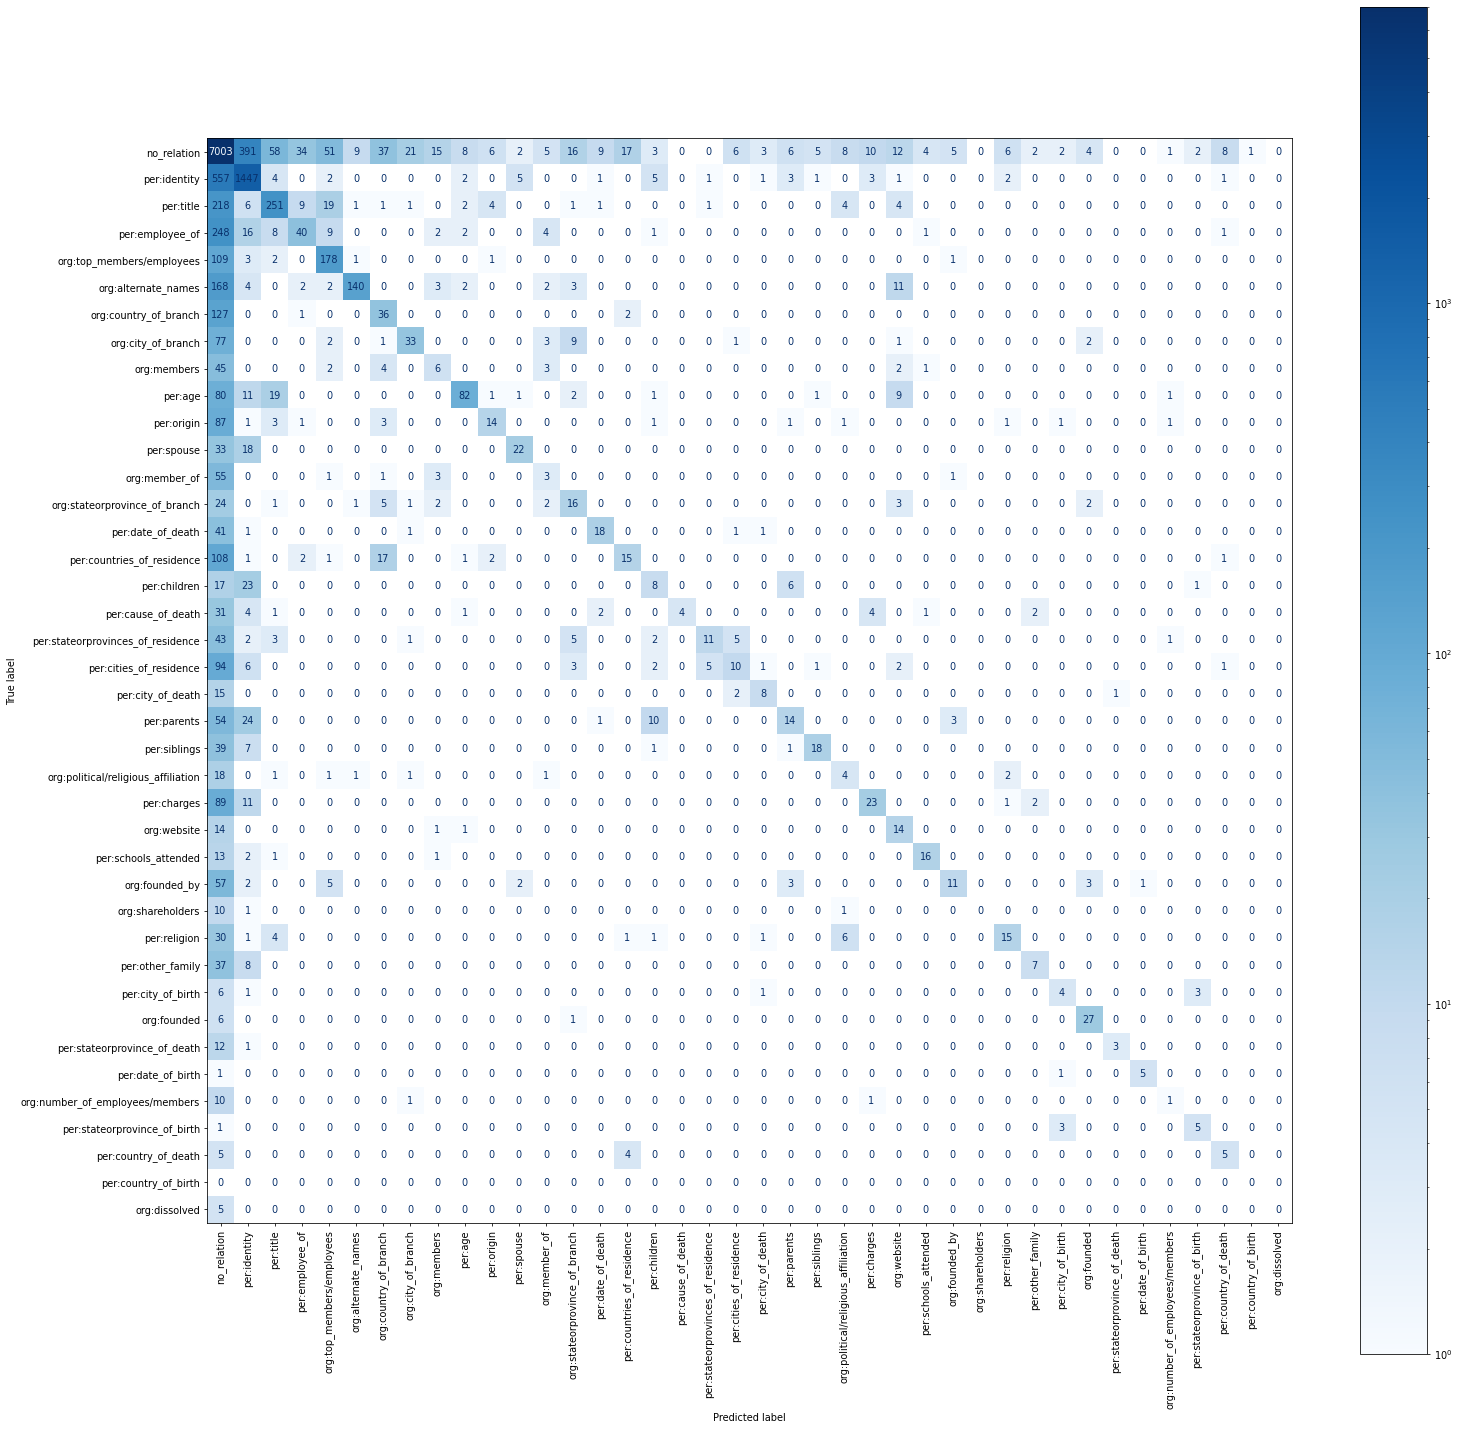

In [18]:
# Creates confusion matrix
cm = confusion_matrix(true_data_0, predictions_0, labels=np.arange(len(labels)))

# Plots confusion matrix
fig, ax = plt.subplots(**BIG_FIG_PARAMS)
dis = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
dis.plot(ax=ax, **PLOT_PARAMS)
plt.show()

In [19]:
# Calculates classification report and accuracy of test results
report_0 = classification_report(true_data_0, predictions_0, labels=np.arange(len(labels)), target_names=labels, **REPORT_PARAMS)
accuracy_0 = accuracy_score(true_data_0, predictions_0)

print(f"Accuracy: {accuracy_0 * 100:.2f}%\n", "Classification Report", report_0, sep="\n")

Accuracy: 70.93%

Classification Report
                                     precision    recall  f1-score   support

                        no_relation      0.730     0.901     0.807      7770
                       per:identity      0.726     0.711     0.718      2036
                          per:title      0.705     0.480     0.571       523
                    per:employee_of      0.449     0.120     0.190       332
          org:top_members/employees      0.652     0.603     0.627       295
                org:alternate_names      0.915     0.415     0.571       337
              org:country_of_branch      0.343     0.217     0.266       166
                 org:city_of_branch      0.550     0.256     0.349       129
                        org:members      0.182     0.095     0.125        63
                            per:age      0.812     0.394     0.531       208
                         per:origin      0.500     0.122     0.196       115
                         per:spouse

In [20]:
# Packages vectoriser and RelExLSTM
full_model0 = create_RelExLSTM_with_vectoriser(model0, vectoriser, MAX_LEN)
full_model0.save(MODEL0_PATH)

### Two-Stage Classifier Approach

The two-stage classifier approach uses two RelExLSTM models. The first is a binary model to classify `"has_relation"` or `"no_relation"`. The second is a multi-class model to categorise `NUM_LABELS - 1` categories, excluding `"no_relation"`.

This model looks to address misclassification in the single classifier approach caused by an imbalance in the sample size for the `"no_relation"` class compared to the other classes.

#### Binary Classifier

For classification of `"has_relation"` or `"no_relation"`, the model has been adapted for binary classification in the following ways:
- Only outputting a single label - 0 for `"no_relation"`, 1 for `"has_relation"`
- Using **sigmoid activation** for the output layer
- Using **binary cross-entropy loss** as the loss function for gradient decent


In [21]:
model10 = create_RelExLSTM(
    vocab_size=VOCAB_SIZE,
    max_len=MAX_LEN,
    text_embed_size=TEXT_EMEDDING_SIZE,
    pos_embed_size=POS_EMEDDING_SIZE,
    lstm_units=LSTM_UNITS,
    num_labels=1,
)

model10.build([(MAX_LEN,), (MAX_LEN,), (MAX_LEN,)])
model10.compile(optimizer=Adam(learning_rate=LR), loss=BinaryCrossentropy(), metrics=["acc"])
model10.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 TextInput (InputLayer)      [(None, 100)]                0         []                            
                                                                                                  
 Position1Input (InputLayer  [(None, 100)]                0         []                            
 )                                                                                                
                                                                                                  
 Position2Input (InputLayer  [(None, 100)]                0         []                            
 )                                                                                                
                                                                                            

##### Model Training

For training, `X`, `X1` and `X2` will be used again. However, `y1` will now be used for the training labels. `X` will be preprocessed again too, giving `X_pp`.

In [22]:
# Prepares text input
X_pp = vectoriser(X)

# Trains model
model10.fit(
    [X_pp, X1, X2],
    y1,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=VAL_SPLIT,
    callbacks=[ckpt_callback_10]
)

# Loads weights producing highest validation accuracy into model
model10.load_weights(CKPT_PATH_10)

Epoch 1/20
519/519 [==============================] - 58s 102ms/step - loss: 0.5375 - acc: 0.7342 - val_loss: 0.5027 - val_acc: 0.7567
Epoch 2/20
519/519 [==============================] - 25s 49ms/step - loss: 0.4067 - acc: 0.8175 - val_loss: 0.4502 - val_acc: 0.7928
Epoch 3/20
519/519 [==============================] - 22s 43ms/step - loss: 0.3356 - acc: 0.8550 - val_loss: 0.4363 - val_acc: 0.8042
Epoch 4/20
519/519 [==============================] - 20s 39ms/step - loss: 0.2831 - acc: 0.8788 - val_loss: 0.4758 - val_acc: 0.8000
Epoch 5/20
519/519 [==============================] - 21s 40ms/step - loss: 0.2419 - acc: 0.8989 - val_loss: 0.4849 - val_acc: 0.8038
Epoch 6/20
519/519 [==============================] - 18s 35ms/step - loss: 0.2098 - acc: 0.9126 - val_loss: 0.5051 - val_acc: 0.8099
Epoch 7/20
519/519 [==============================] - 20s 39ms/step - loss: 0.1783 - acc: 0.9271 - val_loss: 0.5503 - val_acc: 0.8113
Epoch 8/20
519/519 [==============================] - 18s 36m

##### Model Evalution

For testing, `X_test`, `X1_test` and `X2_test` will be used again. Like with training, `y1_test` will be used for validating the testing results.

In [23]:
# Prepares text input
X_test_pp = vectoriser(X_test)

# Predicts class using model
prediction_probs_10 = model10.predict([X_test_pp, X1_test, X2_test])

# Converts output binary probability into integer label
predictions_10 = classify_binary_out(prediction_probs_10.flatten())[0]

420/420 [==============================] - 4s 6ms/step


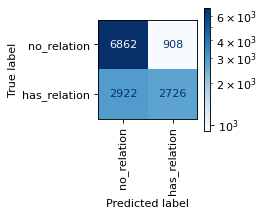

In [24]:
# Creates confusion matrix
cm = confusion_matrix(y1_test, predictions_10)

# Plots confusion matrix
fig, ax = plt.subplots(**SMALL_FIG_PARAMS)
dis = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_binary)
dis.plot(ax=ax, **PLOT_PARAMS)
plt.show()

In [25]:
# Calculates classification report and accuracy of test results
report_10 = classification_report(y1_test, predictions_10, target_names=labels_binary, **REPORT_PARAMS)
accuracy_10 = accuracy_score(y1_test, predictions_10)

print(f"Accuracy: {accuracy_10 * 100:.2f}%\n", "Classification Report", report_10, sep="\n")

Accuracy: 71.46%

Classification Report
              precision    recall  f1-score   support

 no_relation      0.701     0.883     0.782      7770
has_relation      0.750     0.483     0.587      5648

    accuracy                          0.715     13418
   macro avg      0.726     0.683     0.685     13418
weighted avg      0.722     0.715     0.700     13418



In [26]:
# Packages vectoriser and RelExLSTM
full_model10 = create_RelExLSTM_with_vectoriser(model10, vectoriser, MAX_LEN)
full_model10.save(MODEL10_PATH)

#### Multi-class Relation Classifier (Excluding `"no_relation"`)

In [27]:
model11 = create_RelExLSTM(
    text_embed_size=TEXT_EMEDDING_SIZE,
    pos_embed_size=POS_EMEDDING_SIZE,
    lstm_units=LSTM_UNITS,
    vocab_size=VOCAB_SIZE,
    num_labels=NUM_LABELS_FIL,
    max_len=MAX_LEN,
)

model11.build([(MAX_LEN,), (MAX_LEN,), (MAX_LEN,)])
model11.compile(optimizer=Adam(learning_rate=LR), loss=CategoricalCrossentropy(), metrics=["acc"])
model11.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 TextInput (InputLayer)      [(None, 100)]                0         []                            
                                                                                                  
 Position1Input (InputLayer  [(None, 100)]                0         []                            
 )                                                                                                
                                                                                                  
 Position2Input (InputLayer  [(None, 100)]                0         []                            
 )                                                                                                
                                                                                            

##### Model Training

For training, `X_fil`, `X1_fil` and `X2_fil` will be used - this is the data excluding `"no_relation"`-categorised data. `y_fil` will be used for the training labels. `X_fil` is preprocessed like before, giving `X_pp` (with shape `(batch_size, MAX_LEN)`).

In [28]:
# Prepares text input
X_fil_pp = vectoriser(X_fil)

# Trains model
model11.fit(
    [X_fil_pp, X1_fil, X2_fil],
    y_fil,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=VAL_SPLIT,
    callbacks=[ckpt_callback_11]
)

# Loads weights producing highest validation accuracy into model
model11.load_weights(CKPT_PATH_11)

Epoch 1/20
187/187 [==============================] - 37s 173ms/step - loss: 2.2846 - acc: 0.3770 - val_loss: 1.9256 - val_acc: 0.4685
Epoch 2/20
187/187 [==============================] - 14s 74ms/step - loss: 1.4892 - acc: 0.5584 - val_loss: 1.5413 - val_acc: 0.5655
Epoch 3/20
187/187 [==============================] - 11s 59ms/step - loss: 1.1434 - acc: 0.6588 - val_loss: 1.3044 - val_acc: 0.6087
Epoch 4/20
187/187 [==============================] - 9s 50ms/step - loss: 0.9302 - acc: 0.7178 - val_loss: 1.1693 - val_acc: 0.6582
Epoch 5/20
187/187 [==============================] - 10s 53ms/step - loss: 0.7663 - acc: 0.7615 - val_loss: 1.0968 - val_acc: 0.6729
Epoch 6/20
187/187 [==============================] - 8s 45ms/step - loss: 0.6255 - acc: 0.8055 - val_loss: 1.0278 - val_acc: 0.7031
Epoch 7/20
187/187 [==============================] - 9s 46ms/step - loss: 0.5284 - acc: 0.8330 - val_loss: 0.9861 - val_acc: 0.7257
Epoch 8/20
187/187 [==============================] - 9s 44ms/st

##### Model Evaluation

For testing, the filtered `X_test_fil`, `X1_test_fil` and `X2_test_fil` will be used. `y_test_fil` will be used for validating the testing results.

In [29]:
# Prepares text input
X_test_fil_pp = vectoriser(X_test_fil)

# Predicts class using model
prediction_probs_11 = model11.predict([X_test_fil_pp, X1_test_fil, X2_test_fil])

# Converts output mutli-hot label probabilities into integer label
predictions_11 = classify_multiclass_out(prediction_probs_11)
true_data_11 = classify_multiclass_out(y_test_fil)

177/177 [==============================] - 2s 6ms/step


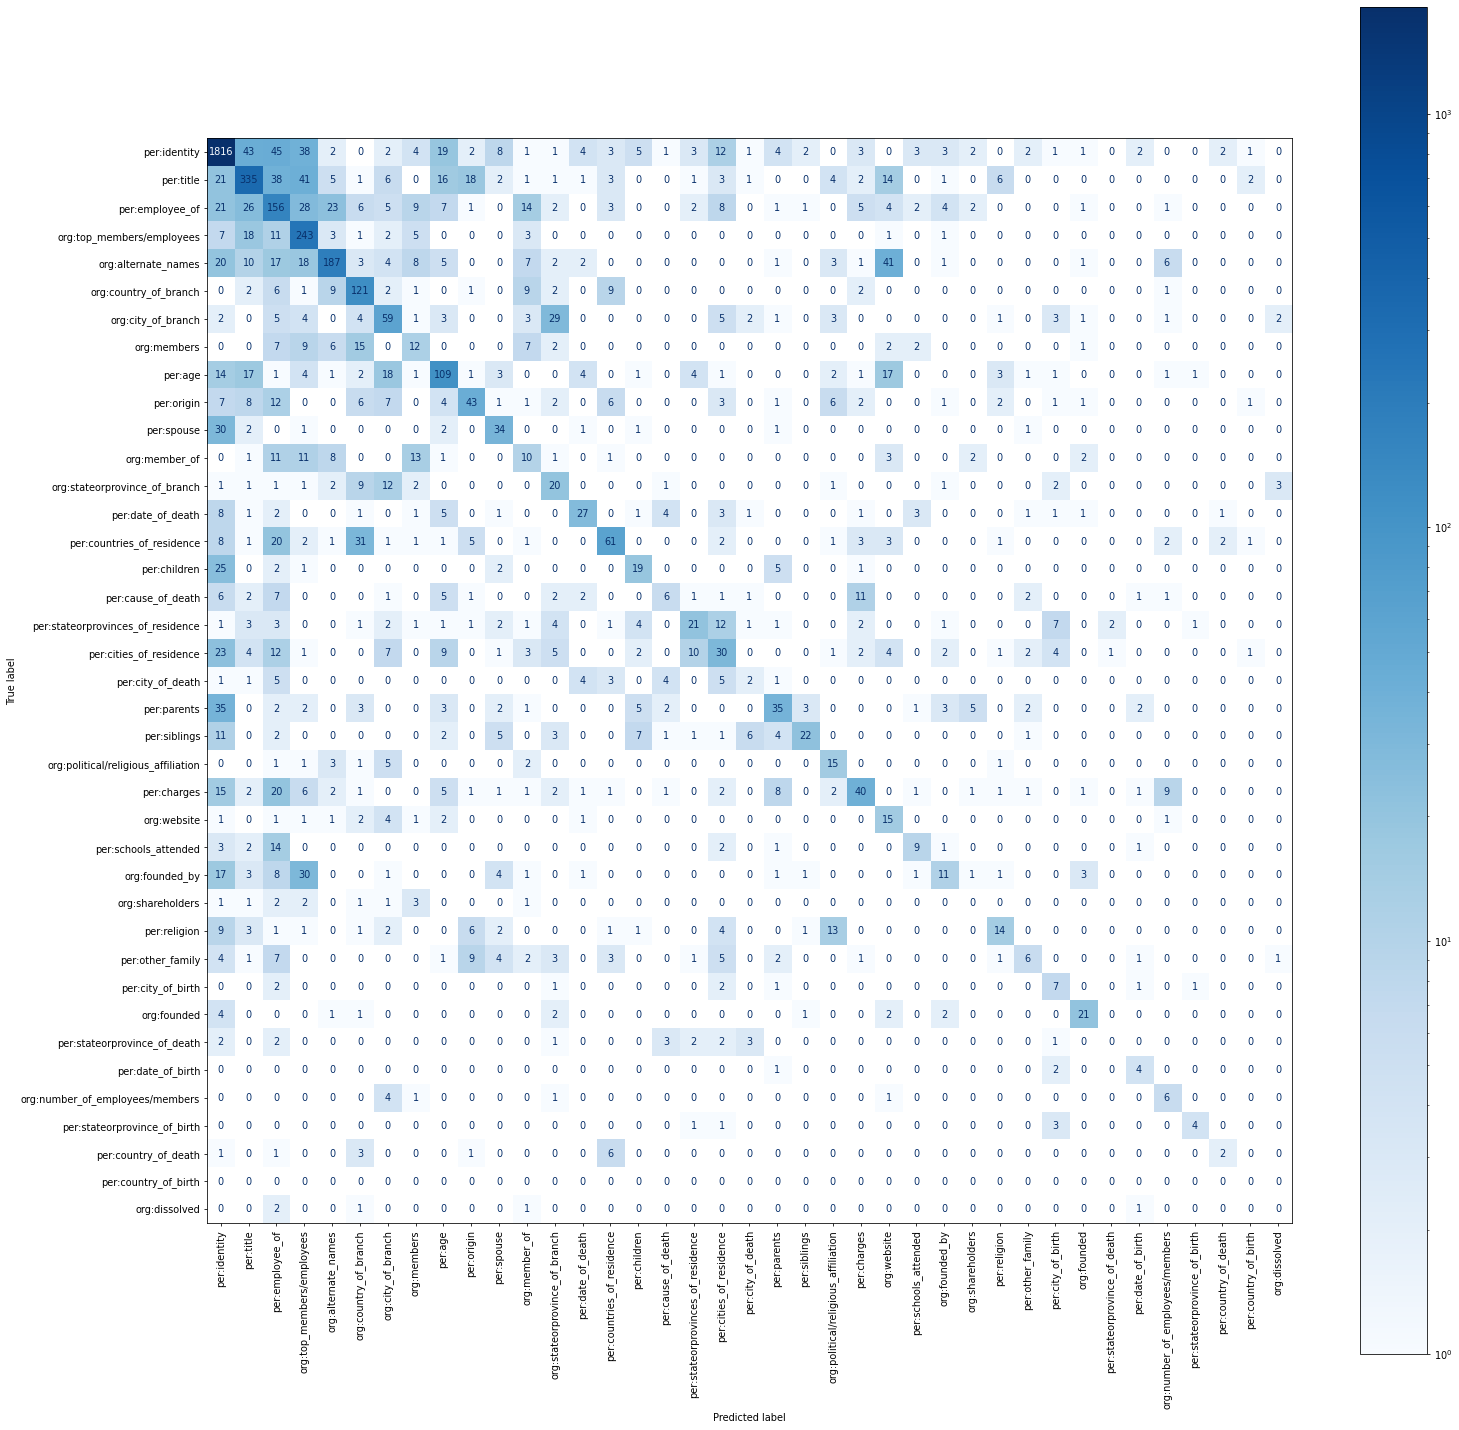

In [30]:
# Creates confusion matrix
cm = confusion_matrix(true_data_11, predictions_11, labels=np.arange(len(labels_filtered)))

# Plots confusion matrix
fig, ax = plt.subplots(**BIG_FIG_PARAMS)
dis = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_filtered)
dis.plot(ax=ax, **PLOT_PARAMS)
plt.show()

In [31]:
# Calculates classification report and accuracy of test results
report_11 = classification_report(true_data_11, predictions_11, labels=np.arange(len(labels_filtered)), target_names=labels_filtered, **REPORT_PARAMS)
accuracy_11 = accuracy_score(true_data_11, predictions_11)

print(f"Accuracy: {accuracy_11 * 100:.2f}%\n", "Classification Report", report_11, sep="\n")

Accuracy: 62.36%

Classification Report
                                     precision    recall  f1-score   support

                       per:identity      0.859     0.892     0.875      2036
                          per:title      0.688     0.641     0.663       523
                    per:employee_of      0.366     0.470     0.412       332
          org:top_members/employees      0.545     0.824     0.656       295
                org:alternate_names      0.736     0.555     0.633       337
              org:country_of_branch      0.563     0.729     0.635       166
                 org:city_of_branch      0.407     0.457     0.431       129
                        org:members      0.188     0.190     0.189        63
                            per:age      0.545     0.524     0.534       208
                         per:origin      0.478     0.374     0.420       115
                         per:spouse      0.472     0.466     0.469        73
                      org:member_of

In [32]:
# Packages vectoriser and RelExLSTM
full_model11 = create_RelExLSTM_with_vectoriser(model11, vectoriser, MAX_LEN)
full_model11.save(MODEL11_PATH)

#### Full Model Evaluation

For testing the full, two-stage classifier, the preprocessed `X_test`, `X1_test` and `X2_test` will first be passed into the binary classifier. The output classifications will then be used to mask the test sets, with only positively predicted samples being passed into the multi-class model. All predicted labels will be compared with `y_test`. This will enable comparisons with the single-stage classifier's performance.

In [33]:
# classes = classify_multiclass_out(y_test)
# no_rel_classes = np.zeros_like(classes[predictions_10 == 0])

In [34]:
# Prepares text input
X_test_pp = vectoriser(X_test)

# Predicts binary class using model
prediction_probs_1a = model10.predict([X_test_pp, X1_test, X2_test])

420/420 [==============================] - 3s 8ms/step


In [35]:
# Splits test dataset based on binary classifications
hr_mask = (prediction_probs_1a >= 0.5).flatten()
X_test_pp_masked = X_test_pp[hr_mask]
X1_test_masked = X1_test[hr_mask]
X2_test_masked = X2_test[hr_mask]

# Predicts relation class using model
prediction_probs_1b = model11.predict([X_test_pp_masked, X1_test_masked, X2_test_masked])

predictions_1 = np.zeros(len(hr_mask))
predictions_1[hr_mask] = classify_multiclass_out(prediction_probs_1b) + 1

true_data_1 = classify_multiclass_out(y_test)

114/114 [==============================] - 1s 7ms/step


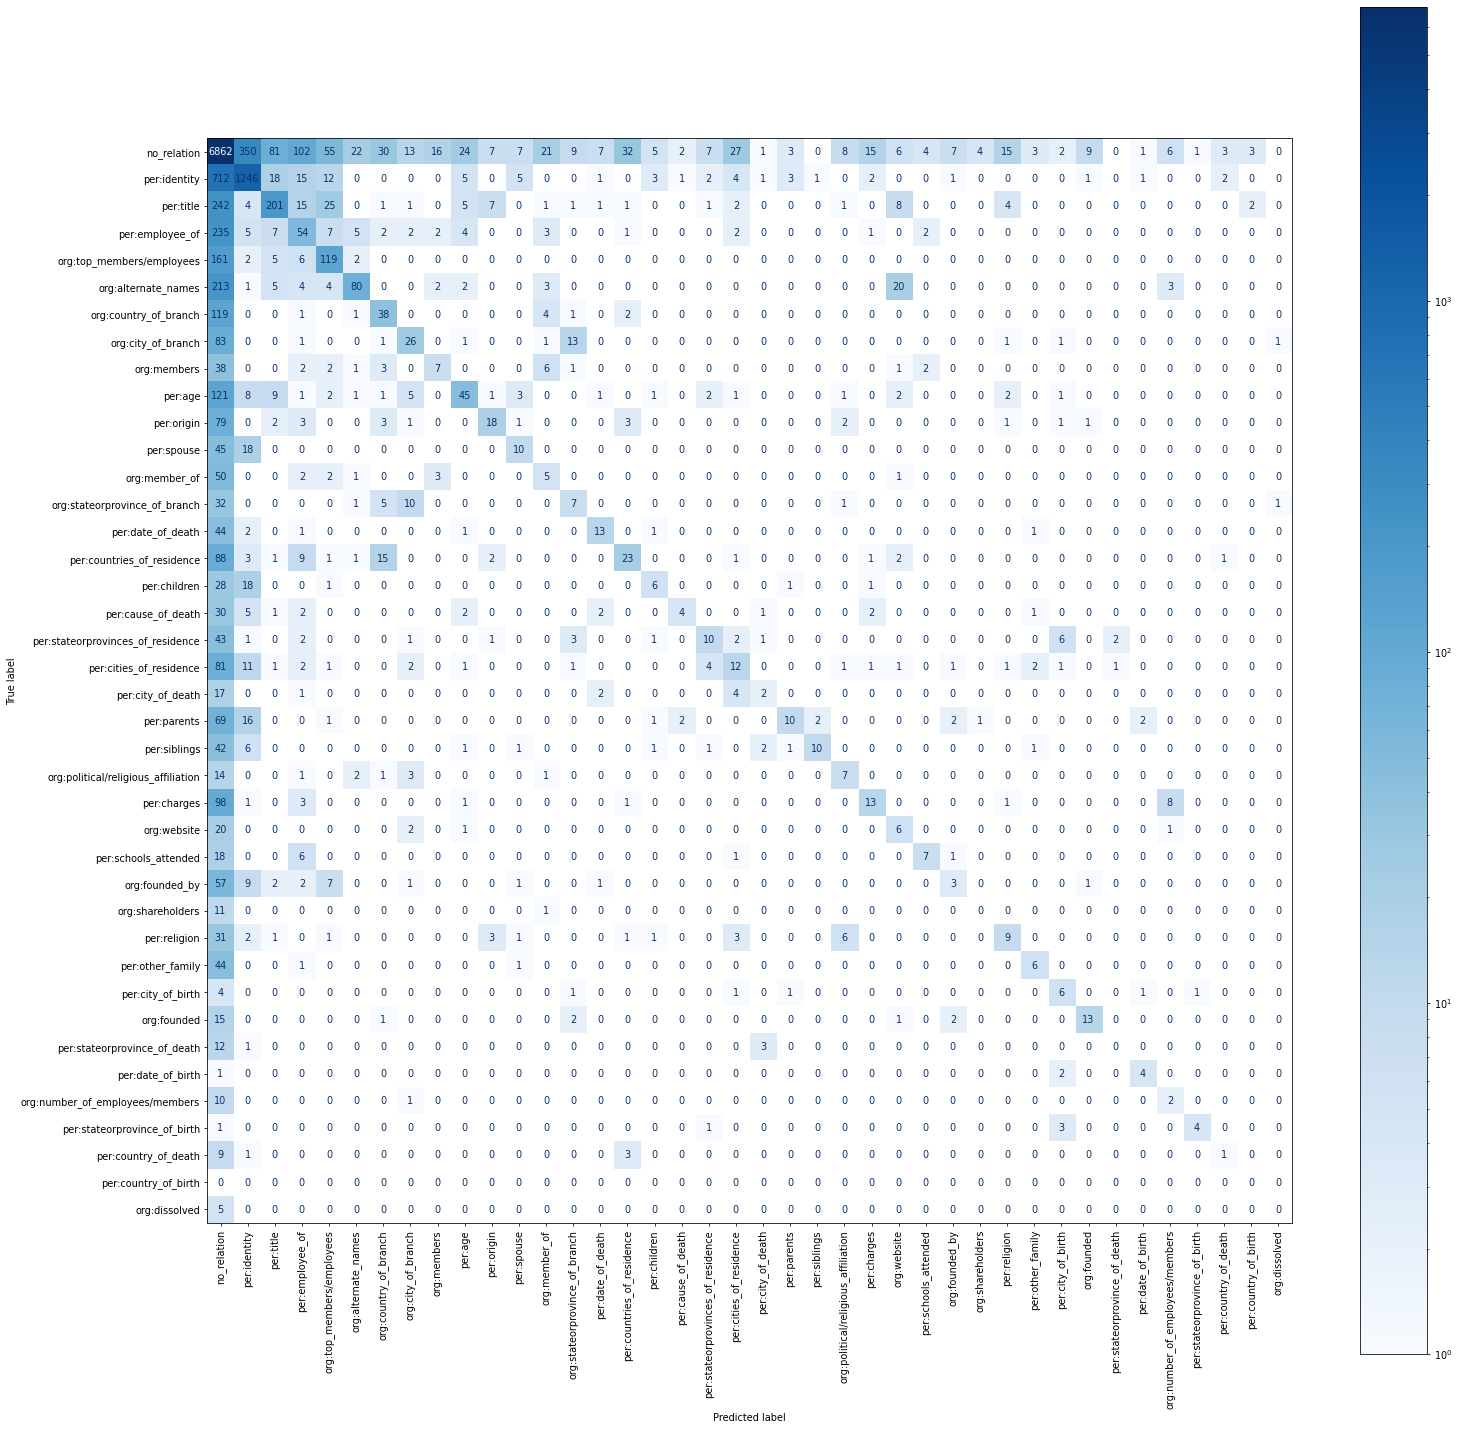

In [36]:
# Creates confusion matrix
cm = confusion_matrix(true_data_1, predictions_1, labels=np.arange(len(labels)))

# Plots confusion matrix
fig, ax = plt.subplots(**BIG_FIG_PARAMS)
dis = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
dis.plot(ax=ax, **PLOT_PARAMS)
plt.show()

In [37]:
# Calculates classification report and accuracy of test results
report_1 = classification_report(true_data_1, predictions_1, labels=np.arange(len(labels)), target_names=labels, **REPORT_PARAMS)
accuracy_1 = accuracy_score(true_data_1, predictions_1)

print(f"Accuracy: {accuracy_1 * 100:.2f}%\n", "Classification Report", report_1, sep="\n")

Accuracy: 66.25%

Classification Report
                                     precision    recall  f1-score   support

                        no_relation      0.701     0.883     0.782      7770
                       per:identity      0.729     0.612     0.665      2036
                          per:title      0.602     0.384     0.469       523
                    per:employee_of      0.229     0.163     0.190       332
          org:top_members/employees      0.496     0.403     0.445       295
                org:alternate_names      0.684     0.237     0.352       337
              org:country_of_branch      0.376     0.229     0.285       166
                 org:city_of_branch      0.382     0.202     0.264       129
                        org:members      0.233     0.111     0.151        63
                            per:age      0.484     0.216     0.299       208
                         per:origin      0.462     0.157     0.234       115
                         per:spouse

## Inference Mode

The inference mode allows a user to input a sentence and the postions the subject and object, and receive an output relation classification.
Enter `\Q` to exit the program.

In [ ]:
def valid_int(x: int, max_len: int) -> bool:
    """
    Checks if integer lies in range `(0, max_len)`.

    Parameters
    ----------
    `x`: `int`
        Integer to check.
    `max_len`: `int`
        Upped bound.

    Returns
    -------
    `bool`
        If integer lies in range.

    """
    return (x >= 0) and (x < max_len)

def parse_pos(string: str) -> tuple[bool, None | tuple[int, int]]:
    """
    Parses a string describing subject or object positioning.

    Parameters
    ----------
    `string`: `str`
        String to parse.

    Returns
    -------
    `bool`
        If string is valid.
    `tuple` of two `int`
        The start and end positions.

    """
    try:
        int_string = int(string)
    except ValueError:

        split_string = re.split(" |-", string)
        try:
            split_string = [int(item) for item in split_string]
        except ValueError:
            return False, None

        if valid_int(split_string[0], MAX_LEN) and valid_int(split_string[1], MAX_LEN):
            print((split_string[0], split_string[1]))
            return True, (split_string[0], split_string[1])

        return False, None


    # if (int_string == -1):
    #     return True, None

    if valid_int(int_string, MAX_LEN):
        return True, (int_string, int_string)

    return False, None


def run_inference(model: Model):
    """
    Runs inference on `model`.

    Parameters
    ----------
    `model`: `tf.keras.Model`
        Keras model to perform inference on.
    """
    run_loop = True
    while run_loop == True:
        # Queries user for sentence
        print("Enter a sentence to parse. (\Q to quit)")
        sentence = input("> ")

        # Quits if escape key entered
        if (sentence == r"\Q"):
            run_loop = False
            continue

        sentence_vec = tf.reshape(tf.convert_to_tensor(sentence, dtype=tf.string), (1,))

        # Queries user for subject position
        is_valid = False
        while is_valid == False:
            print("Enter the position of the subject (either a single number or an inclusive range in the form 'a-b', starting from 0).")
            valid, subj = parse_pos(input("> "))
            subj_pos = create_pos_array(MAX_LEN, *subj).reshape(1, MAX_LEN)
            is_valid = valid

        # Queries user for object position
        is_valid = False
        while is_valid == False:
            print("Enter the position of the object (either a single number or a range in the form 'a-b', starting from 0).")
            valid, obj = parse_pos(input("> "))
            obj_pos = create_pos_array(MAX_LEN, *obj).reshape(1, MAX_LEN)
            is_valid = valid

        # Makes model predictions
        prediction_probs = model.predict([sentence_vec, subj_pos, obj_pos], verbose=0)
        predictions = classify_multiclass_out(prediction_probs)

        print(f"\nPredicted class: {labels[predictions[0]]}\n\n")


# Runs model from file
model_filepath = MODEL0_PATH
run_inference(load_model(model_filepath))